In [ ]:
!pip install feature-engine

     |████████████████████████████████| 180 kB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 25.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install tensorflow 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder

# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

# plot
import seaborn as sns
import matplotlib.pyplot as plt

#scaling
from sklearn.preprocessing import RobustScaler

#deep learning
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Bidirectional
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint


from keras.regularizers import l2


In [ ]:
d2 = pd.read_csv('/content/drive/MyDrive/BTC/mergedFrame4MonthsPart1-onezeronegone.csv', parse_dates= ['Date'], index_col= 'Date')
d1 = pd.read_csv('/content/drive/MyDrive/BTC/mergedFrame4MonthsPart2-onezeronegonecountsadded.csv', parse_dates= ['Date'], index_col= 'Date')
d3 = pd.read_csv('/content/drive/MyDrive/BTC/mergedFrameMayFinal-Status.csv', parse_dates= ['Date'], index_col= 'Date')
d4 = pd.read_csv('/content/drive/MyDrive/BTC/mergedFrameJuneSept.csv', parse_dates= ['Date'], index_col= 'Date')

frames = [d1, d2, d3, d4]
df = pd.concat(frames)

In [ ]:
df.head()

,text,source,user_location,user_followers_count,user_friends_count,retweet_count,favorite_count,retweeted,favorited,hashtag,lang,vaderSentiment,SentimentsAnalysis,Open,High,Low,Close,Percentage Change,1 or 0 or -1,count,Unnamed: 21,Percentage,Count,Status
Date,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 07:01:00,BFBLOCKCHAIN New Years Greetings New Year ball...,"<a href=""http://twitter.com/download/android"" ...",NaN,56.0,236.0,0.0,0.0,False,False,NaN,ja,"{'neg': 0.0, 'neu': 0.922, 'pos': 0.078, 'comp...",Positive,7206.67,7206.67,7203.59,7203.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 07:07:00,How to choose and use bitcoins safely and comf...,"<a href=""http://twittbot.net/"" rel=""nofollow"">...",Ishigaki,10.0,82.0,0.0,0.0,False,False,NaN,ja,"{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'comp...",Positive,7203.66,7203.66,7203.66,7203.66,0.00%,1.0,9358.0,-1.0,NaN,NaN,NaN
2020-01-01 07:08:00,btcp77 Twitter musicalnotes Touchin’ like we k...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,53.0,238.0,0.0,0.0,False,False,"강다니엘,KANGDANIEL",en,"{'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...",Positive,7203.66,7203.66,7203.66,7203.66,0.00%,0.0,8811.0,0.0,NaN,NaN,NaN
2020-01-01 07:09:00,Cointelegraph CNCointelegraph securypto wish y...,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Jakarta, Indonesia",117.0,295.0,0.0,0.0,False,False,"securypto,cryptocurrency,bitcoin,altcoin",en,"{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...",Positive,7203.66,7203.66,7203.66,7203.66,0.00%,0.0,10579.0,1.0,NaN,NaN,NaN
2020-01-01 07:16:00,Victori2260642 grinningfacewithbigeyessmilingf...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",ecuador,21.0,182.0,0.0,0.0,False,False,"Sexual,ass,sex",en,"{'neg': 0.226, 'neu': 0.774, 'pos': 0.0, 'comp...",Negative,7206.89,7208.38,7195.85,7206.95,0.05%,1.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1 = df.iloc[:,[3,4,-12, 13,14, 15, -8]]
df1.head()

,user_followers_count,user_friends_count,SentimentsAnalysis,Open,High,Low,Close
Date,,,,,,,
2020-01-01 07:01:00,56.0,236.0,Positive,7206.67,7206.67,7203.59,7203.59
2020-01-01 07:07:00,10.0,82.0,Positive,7203.66,7203.66,7203.66,7203.66
2020-01-01 07:08:00,53.0,238.0,Positive,7203.66,7203.66,7203.66,7203.66
2020-01-01 07:09:00,117.0,295.0,Positive,7203.66,7203.66,7203.66,7203.66
2020-01-01 07:16:00,21.0,182.0,Negative,7206.89,7208.38,7195.85,7206.95


Missing Value check

In [ ]:
df1.isnull().mean()

user_followers_count    0.006919
user_friends_count      0.006919
SentimentsAnalysis      0.000047
Open                    0.000047
High                    0.000047
Low                     0.000047
Close                   0.000047
dtype: float64

In [ ]:
df1['hour'] = df.index.hour
df1['day_of_week'] = df.index.dayofweek
df1['day_of_month'] = df.index.day
df1['month'] = df.index.month

In [ ]:
df1.head()

,user_followers_count,user_friends_count,SentimentsAnalysis,Open,High,Low,Close,hour,day_of_week,day_of_month,month
Date,,,,,,,,,,,
2020-01-01 07:01:00,56.0,236.0,Positive,7206.67,7206.67,7203.59,7203.59,7.0,2.0,1.0,1.0
2020-01-01 07:07:00,10.0,82.0,Positive,7203.66,7203.66,7203.66,7203.66,7.0,2.0,1.0,1.0
2020-01-01 07:08:00,53.0,238.0,Positive,7203.66,7203.66,7203.66,7203.66,7.0,2.0,1.0,1.0
2020-01-01 07:09:00,117.0,295.0,Positive,7203.66,7203.66,7203.66,7203.66,7.0,2.0,1.0,1.0
2020-01-01 07:16:00,21.0,182.0,Negative,7206.89,7208.38,7195.85,7206.95,7.0,2.0,1.0,1.0


The data is too frequent, in minutes and seconds. Lets move to hours

In [ ]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    variables=['SentimentsAnalysis'],  # we can select which variables to encode
    drop_last=False)  # to return k-1, false to return k


ohe_enc.fit(df1.fillna(0))
df = ohe_enc.transform(df1.fillna(-1))


In [ ]:
df_by_hours = df.resample('8H').mean()

In [ ]:
df_by_hours

,user_followers_count,user_friends_count,Open,High,Low,Close,hour,day_of_week,day_of_month,month,SentimentsAnalysis_Positive,SentimentsAnalysis_Negative,SentimentsAnalysis_Neutral,SentimentsAnalysis_0
Date,,,,,,,,,,,,,,
2020-01-01 00:00:00,2476.133333,295.933333,7199.697333,7200.066000,7198.657333,7199.655333,7.000000,2.0,1.0,1.0,0.600000,0.200000,0.200000,0.0
2020-01-01 08:00:00,2478.596639,1055.831933,7190.280924,7193.075042,7189.569580,7190.687647,11.605042,2.0,1.0,1.0,0.495798,0.134454,0.369748,0.0
2020-01-01 16:00:00,5568.864407,1153.288136,7204.987288,7206.472627,7204.295508,7205.008220,19.398305,2.0,1.0,1.0,0.364407,0.161017,0.474576,0.0
2020-01-02 00:00:00,5431.683168,811.118812,7135.692079,7136.875743,7134.801881,7135.618812,3.198020,3.0,2.0,1.0,0.475248,0.168317,0.356436,0.0
2020-01-02 08:00:00,2503.941176,787.554622,7123.011597,7123.954286,7122.142689,7122.643025,11.277311,3.0,2.0,1.0,0.361345,0.210084,0.428571,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-29 16:00:00,775.666667,776.666667,10719.170000,10720.626667,10719.116667,10719.190000,17.666667,1.0,29.0,9.0,0.333333,0.000000,0.666667,0.0
2020-09-30 00:00:00,86.666667,261.666667,10752.690000,10752.690000,10752.513333,10752.513333,4.666667,2.0,30.0,9.0,0.333333,0.333333,0.333333,0.0
2020-09-30 08:00:00,604.375000,1162.500000,10740.595000,10742.245000,10739.348750,10741.302500,13.250000,2.0,30.0,9.0,0.250000,0.000000,0.750000,0.0


**For plot I am using data by day**

In [ ]:
df_by_day = df.resample('D').mean()
df_by_day.head()

,user_followers_count,user_friends_count,Open,High,Low,Close,hour,day_of_week,day_of_month,month,SentimentsAnalysis_Positive,SentimentsAnalysis_Negative,SentimentsAnalysis_Neutral,SentimentsAnalysis_0
Date,,,,,,,,,,,,,,
2020-01-01,3925.480159,1056.234127,7197.727738,7199.764643,7197.005992,7197.927103,14.980159,2.0,1.0,1.0,0.440476,0.150794,0.408730,0.0
2020-01-02,3404.061972,1043.140845,7067.587296,7069.440873,7066.029746,7067.253099,11.974648,3.0,2.0,1.0,0.388732,0.219718,0.391549,0.0
2020-01-03,8022.226190,983.964286,7026.797738,7029.950952,7023.741071,7025.888333,3.000000,4.0,3.0,1.0,0.238095,0.333333,0.428571,0.0
2020-01-04,3124.413127,2126.629344,7320.435946,7322.537568,7319.664247,7320.484247,15.274131,5.0,4.0,1.0,0.386100,0.250965,0.362934,0.0
2020-01-05,1831.733746,1146.117647,7429.881300,7431.603932,7428.926409,7429.874861,11.984520,6.0,5.0,1.0,0.349845,0.216718,0.433437,0.0


**Below the plots answer the question do tweeter sentiment affects bitcoin prices**

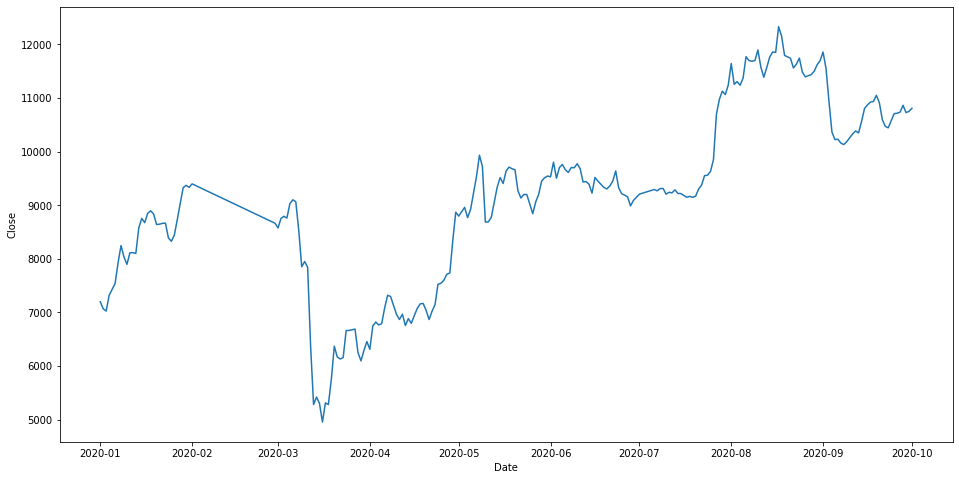

In [ ]:
plt.figure(figsize = (16,8))
sns.lineplot(x = df_by_day.index, y = 'Close', data = df_by_day)
plt.show()

**Negative sentiments were on the rise when the prices was falling**

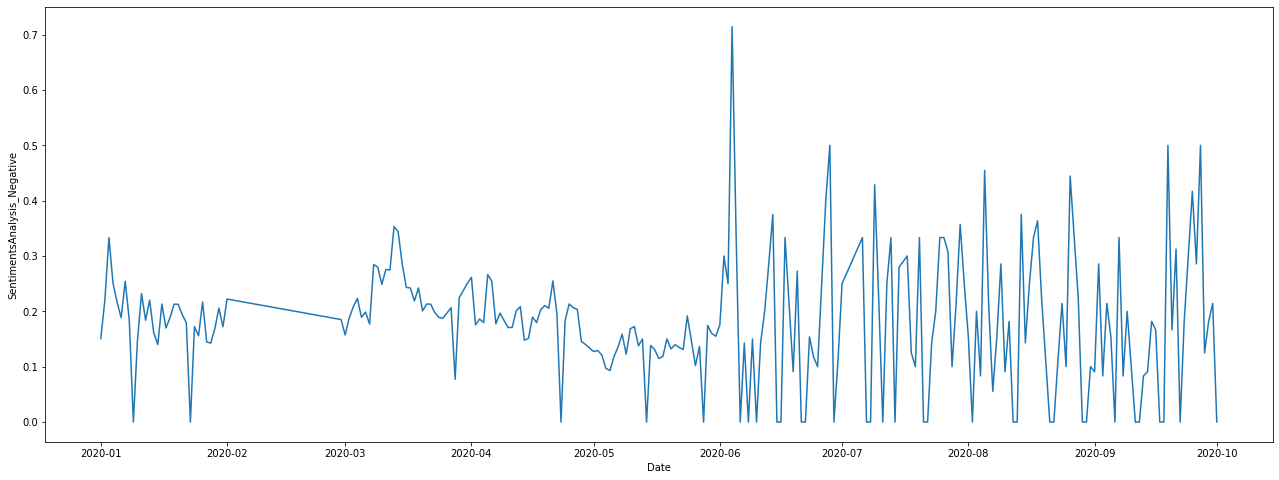

In [ ]:
plt.figure(figsize = (22,8))
sns.lineplot(x = df_by_day.index, y = 'SentimentsAnalysis_Negative', data = df_by_day)
plt.show()

**With increasing price we see a strong positive market sentiment**

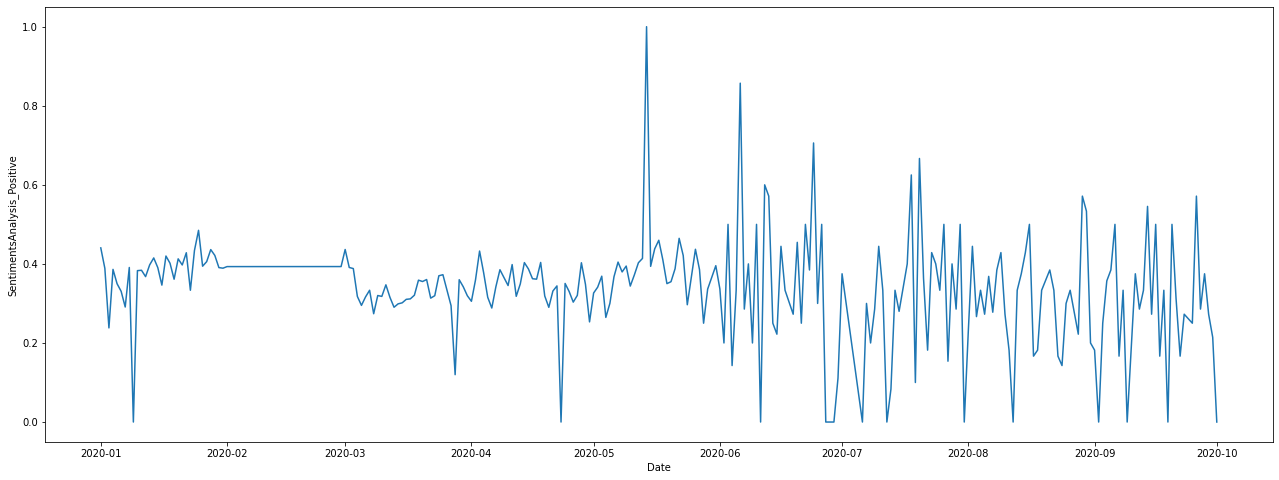

<Figure size 1584x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (22,8))
sns.lineplot(x = df_by_day.index, y = 'SentimentsAnalysis_Positive', data = df_by_day)
plt.figure(figsize=(22,10))
plt.show()

**ALot of people who are tweeting during the great fall were famous people with huge followers, wanted to keep hype in the market**

In [ ]:
plt.figure(figsize = (22,8))
sns.lineplot(x = df_by_day.index, y = 'user_followers_count', data = df_by_day)
plt.figure(figsize=(22,10))
plt.show()

<Figure size 1584x720 with 0 Axes>

In [ ]:
df_by_hours.head()

In [ ]:
df1 = df_by_hours.iloc[:,[0,1,2,3,4,5,-2,-3,-4]]

**Dataset being used**

In [ ]:
df1.head()

In [ ]:
train_dates= df1.index

In [ ]:

df1.fillna(df1.mean(), inplace=True)

In [ ]:
df1.isnull().sum()

user_followers_count           0
user_friends_count             0
Open                           0
High                           0
Low                            0
Close                          0
SentimentsAnalysis_Neutral     0
SentimentsAnalysis_Negative    0
SentimentsAnalysis_Positive    0
dtype: int64

In [ ]:
train_size = int(len(df1) * 0.89)
test_size = len(df1) - train_size

train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]

print(train.shape, test.shape)

(732, 9) (91, 9)


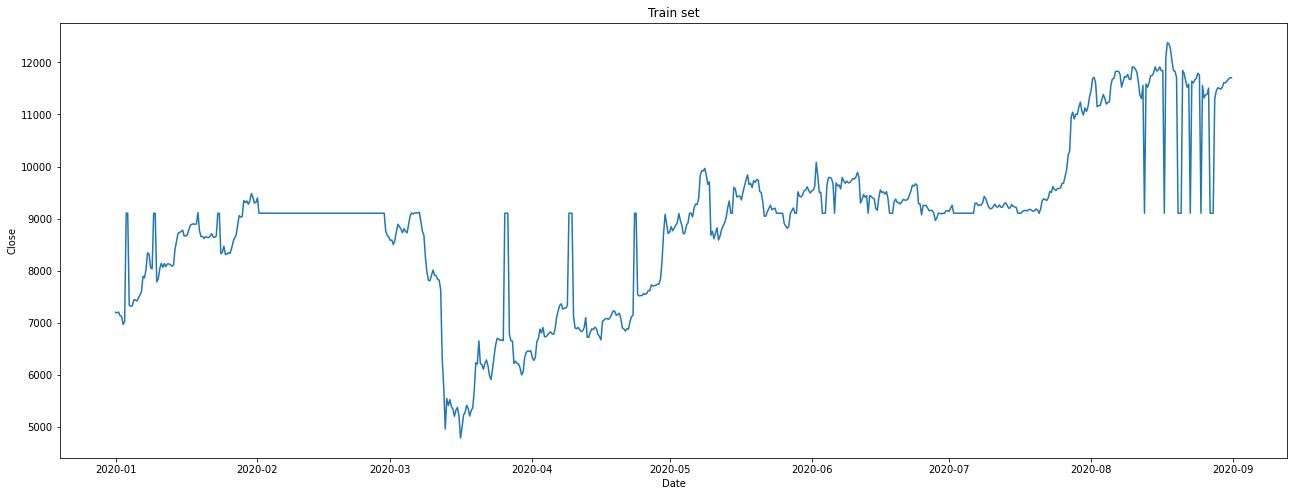

In [ ]:
plt.figure(figsize=(22,8))
sns.lineplot(x = train.index, y = 'Close', data = train)
plt.title('Train set')
plt.show()



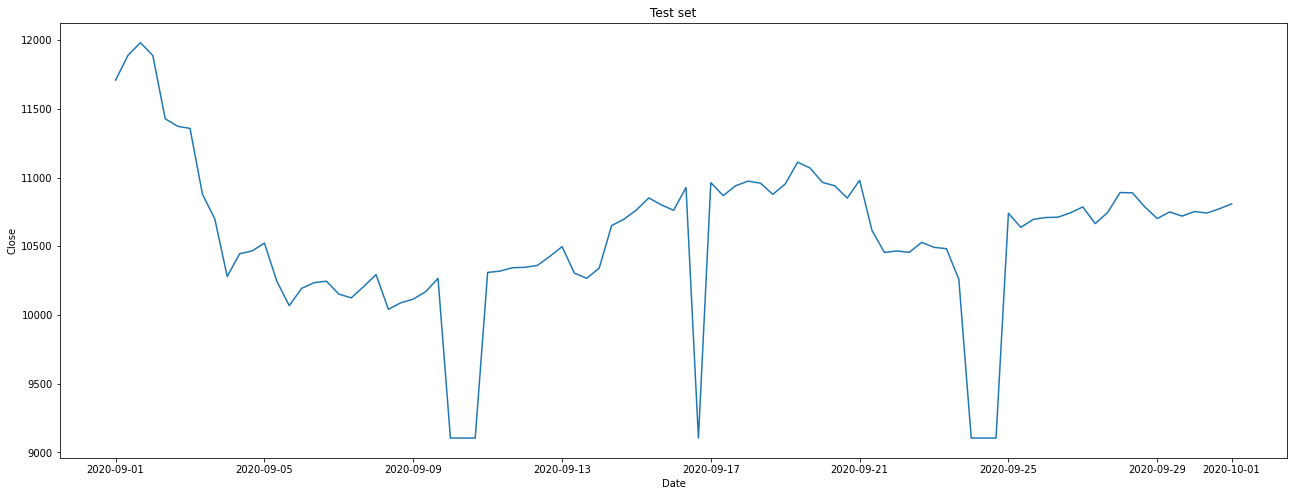

In [ ]:
plt.figure(figsize=(22,8))
sns.lineplot(x = test.index, y = 'Close', data = test)
plt.title('Test set')
plt.show()

In [ ]:
d = pd.DataFrame([train.index, train.Close]).T
d.to_csv('/content/drive/MyDrive/BTC/filename1.csv') 


In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = [cols for cols in df1.columns]
f_columns.remove('Close')
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

In [ ]:
Close_transformer = RobustScaler()
Close_transformer = Close_transformer.fit(train[['Close']])
train['Close'] = Close_transformer.transform(train[['Close']])
test['Close'] = Close_transformer.transform(test[['Close']])

In [ ]:
train.shape, test.shape

((732, 9), (91, 9))

In [ ]:
u = list(test.index)
u = pd.DataFrame(u)
u.head(8)

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)



time_steps = 4
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)
print(X_train.shape, y_train.shape)

(728, 4, 9) (728,)


In [ ]:
u_test, u1_test = create_dataset(u, u, time_steps)

In [ ]:
u_test

In [ ]:
u_test

In [ ]:
X_train[:][4][:]

In [ ]:
print(X_test.shape, y_test.shape)

In [ ]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.10,
    shuffle=False
)

Epoch 1/60
11/11 [==============================] - 6s 112ms/step - loss: 1.4608 - val_loss: 4.8705
Epoch 2/60
11/11 [==============================] - 1s 48ms/step - loss: 1.3999 - val_loss: 4.7779
Epoch 3/60
11/11 [==============================] - 1s 52ms/step - loss: 1.3121 - val_loss: 4.6550
Epoch 4/60
11/11 [==============================] - 1s 50ms/step - loss: 1.1118 - val_loss: 4.3637
Epoch 5/60
11/11 [==============================] - 1s 52ms/step - loss: 0.6358 - val_loss: 3.5230
Epoch 6/60
11/11 [==============================] - 1s 52ms/step - loss: 4.9557 - val_loss: 2.0674
Epoch 7/60
11/11 [==============================] - 1s 48ms/step - loss: 0.5065 - val_loss: 1.4501
Epoch 8/60
11/11 [==============================] - 1s 51ms/step - loss: 0.5335 - val_loss: 1.4234
Epoch 9/60
11/11 [==============================] - 1s 47ms/step - loss: 0.5692 - val_loss: 1.5940
Epoch 10/60
11/11 [==============================] - 1s 53ms/step - loss: 0.5682 - val_loss: 1.7525
Epoch 11

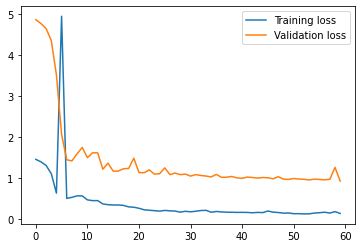

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
y_pred =    model.predict(X_test)
y_pred_tr = model.predict(X_train)

In [ ]:
y_train_inv = Close_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = Close_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = Close_transformer.inverse_transform(y_pred)
y_pred_tr_inv = Close_transformer.inverse_transform(y_pred_tr)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test_inv.flatten(),y_pred_inv.flatten()),)

499.25580330099916

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w



In [ ]:
moa_p = moving_average(y_pred_inv.flatten(),8)
moa_o = moving_average(y_test_inv.flatten(),8)

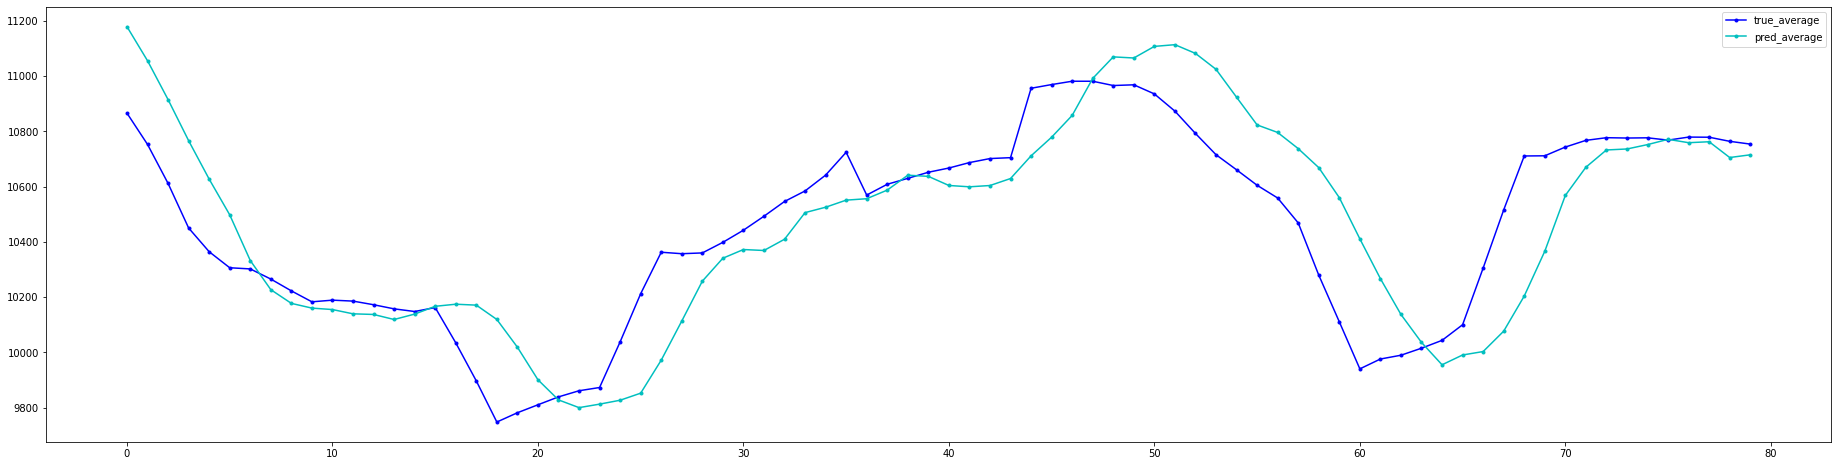

In [ ]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(32,8))
#plt.plot(y_test_inv.flatten(),'g',marker = '*', label ='true')
plt.plot(moa_o,'b',marker = '.', label ='true_average')

#plt.plot(y_pred_inv.flatten(),'r', marker = '*', label ='predicted')
plt.plot(moa_p,'c',marker = '.', label ='pred_average')

plt.legend()
plt.savefig("High resoltion.png",dpi=300)
plt.show()


In [ ]:
y_test_inv